Dataset Head:
            CAS   Names                                             smiles  \
0  1821122-35-3   H4CTT  OC(C(C=C1)=CC=C1C2=CC3=C(C=C2C4=CC=C(C(O)=O)C=...   
1  1835723-11-9   H6PET  OC(C(C=C1)=CC=C1C2=CC(C34)=C(C(C5=C4C=C(C6=CC=...   
2    14609-54-2    TCPP  O=C(O)C(C=C1)=CC=C1/C(C2=CC=C(/C(C3=CC=C(C(O)=...   
3  1331745-95-9   TDCPB  O=C(O)C(C=C1)=CC=C1C2=CC(C3=CC(C4=CC(C5=CC=C(C...   
4    70152-54-4  m-TCPP  O=C(C1=CC(/C(C2=CC=C(/C(C3=CC=CC(C(O)=O)=C3)=C...   

   1H-NMR CA proton  13C-NMR CA carbon  IR unsymmetric CA stretching  pKa H2O  \
0             12.96             167.70                        1691.5     2.19   
1             12.92             167.59                           NaN     2.36   
2             13.22             168.01                        1688.8     2.33   
3             13.01             167.79                        1695.1     2.31   
4             13.35             168.00                        1694.0     2.36   

   pKa DMSO  Absorbance at 420

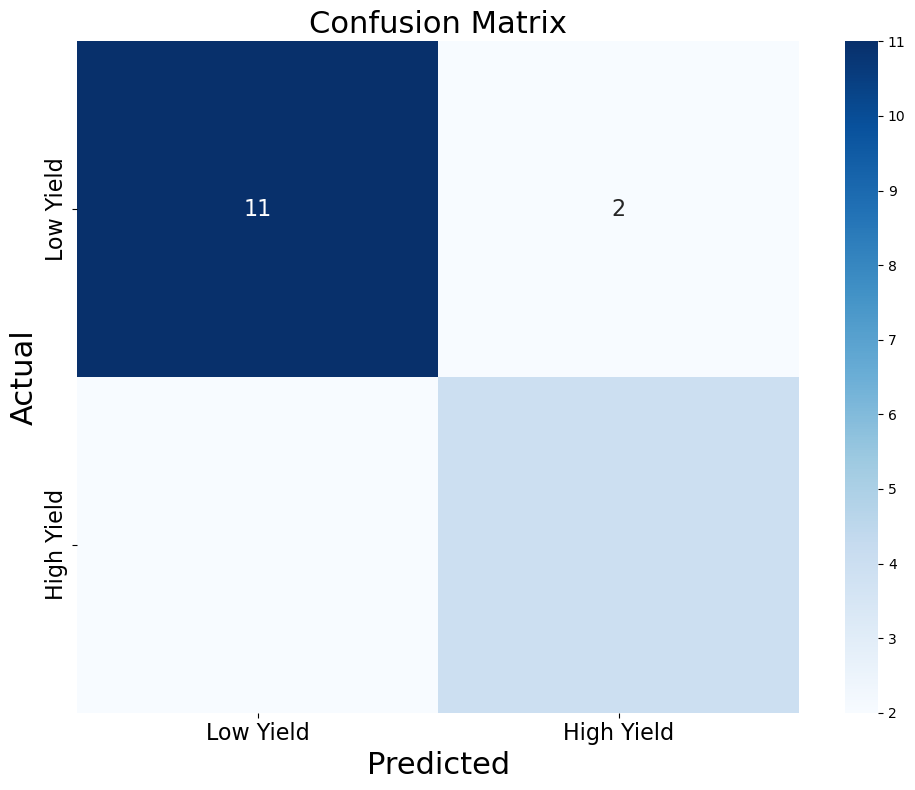

|--- IR unsymmetric CA stretching <= 1681.30
|   |--- class: 0
|--- IR unsymmetric CA stretching >  1681.30
|   |--- 1H-NMR CA proton <= 13.31
|   |   |--- Absorbance at 420 nm (lgA) <= 0.18
|   |   |   |--- class: 0
|   |   |--- Absorbance at 420 nm (lgA) >  0.18
|   |   |   |--- 13C-NMR CA carbon <= 167.40
|   |   |   |   |--- pKa DMSO <= 7.31
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- pKa DMSO >  7.31
|   |   |   |   |   |--- class: 1
|   |   |   |--- 13C-NMR CA carbon >  167.40
|   |   |   |   |--- class: 1
|   |--- 1H-NMR CA proton >  13.31
|   |   |--- class: 0



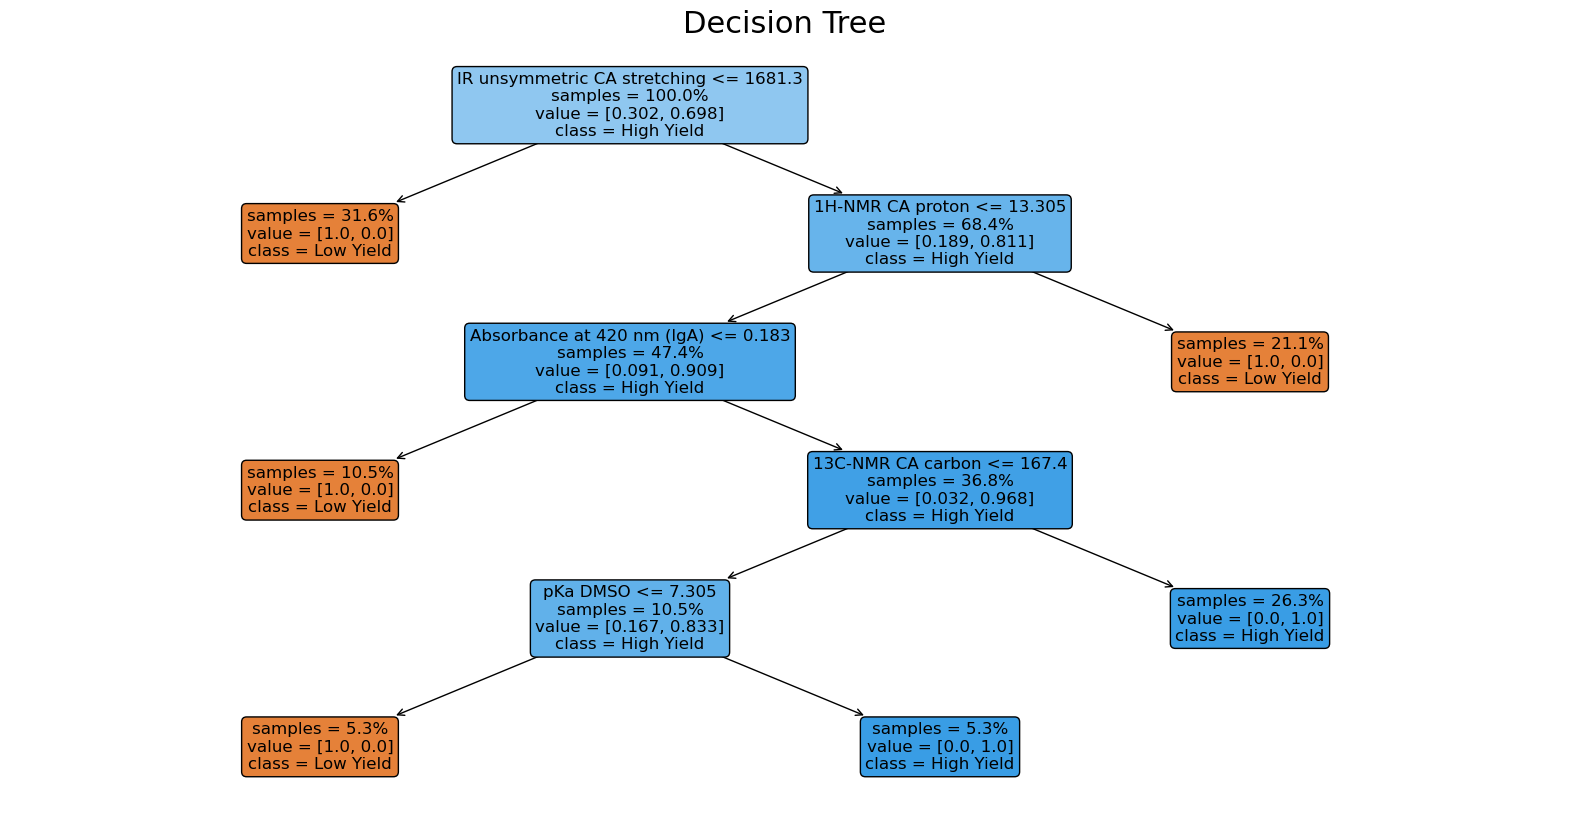

Mislabelled Data Yields:
    Yield
7    2.46
11   6.56
13   0.00
16   5.00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# If running in an interactive IPython environment, this will ensure inline plotting
try:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

# Load the dataset
file_path = 'carboxylates.csv'
df = pd.read_csv(file_path)

# Inspect the dataset
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())

# Drop rows with missing values
df = df.dropna()

# Convert the problem to a classification problem
# Define high yield as yield >=5, and low yield as yield < 5
df['Yield_Class'] = np.where(df['Yield'] >= 5, 1, 0)

# Split the dataset into features and target variable for classification
X = df.drop(columns=['CAS', 'Names', 'smiles', 'Yield', 'Yield_Class'])
y = df['Yield_Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the DecisionTreeClassifier with class weights
class_weights = {1: 5, 0: 1}
hyperparameters = {
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'class_weight': class_weights
}
classifier = DecisionTreeClassifier(random_state=42, **hyperparameters)

# Initialize LOOCV for classification
accuracy_list = []
y_true = []
y_pred_class_list = []

# Perform LOOCV for classification
loo = LeaveOneOut()
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    classifier.fit(X_train, y_train)
    y_pred_class = classifier.predict(X_test)

    accuracy_list.append(accuracy_score(y_test, y_pred_class))
    y_true.extend(y_test)
    y_pred_class_list.extend(y_pred_class)

# Calculate average accuracy
mean_accuracy = np.mean(accuracy_list)

print(f"Classification Model Accuracy: {mean_accuracy}")
print("Classification Report:")
print(classification_report(y_true, y_pred_class_list, target_names=['Low Yield', 'High Yield']))

# Plotting the classification results
plt.figure(figsize=(10, 8))
conf_mat = confusion_matrix(y_true, y_pred_class_list)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)
plt.title("Confusion Matrix", fontsize=22)
plt.xticks(ticks=[0.5, 1.5], labels=['Low Yield', 'High Yield'], fontsize=16)
plt.yticks(ticks=[0.5, 1.5], labels=['Low Yield', 'High Yield'], fontsize=16)
plt.tight_layout()
plt.show()

# Train the classifier on the full dataset for visualization
classifier.fit(X, y)

# Print the decision tree as text
tree_text = export_text(classifier, feature_names=list(X.columns))
print(tree_text)

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(classifier, feature_names=list(X.columns), class_names=['Low Yield', 'High Yield'], filled=True, rounded=True, fontsize=12, proportion=True, impurity=False)
plt.title('Decision Tree', fontsize=22)
plt.show()

# Collect mislabelled data
mislabelled_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred_class_list)) if true != pred]
mislabelled_data = df.iloc[mislabelled_indices]

# Show their yields
print("Mislabelled Data Yields:")
print(mislabelled_data[['Yield']])


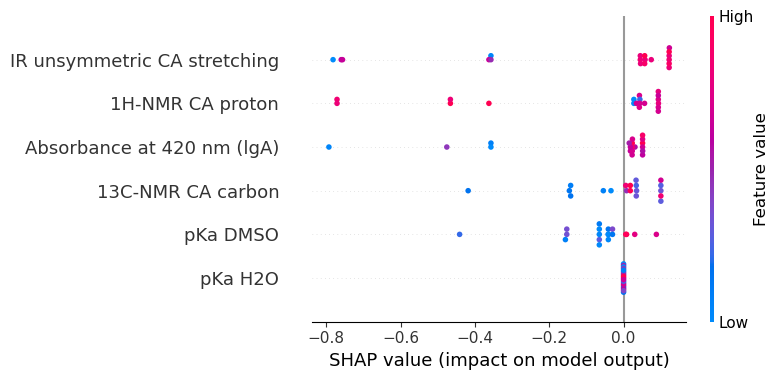

<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

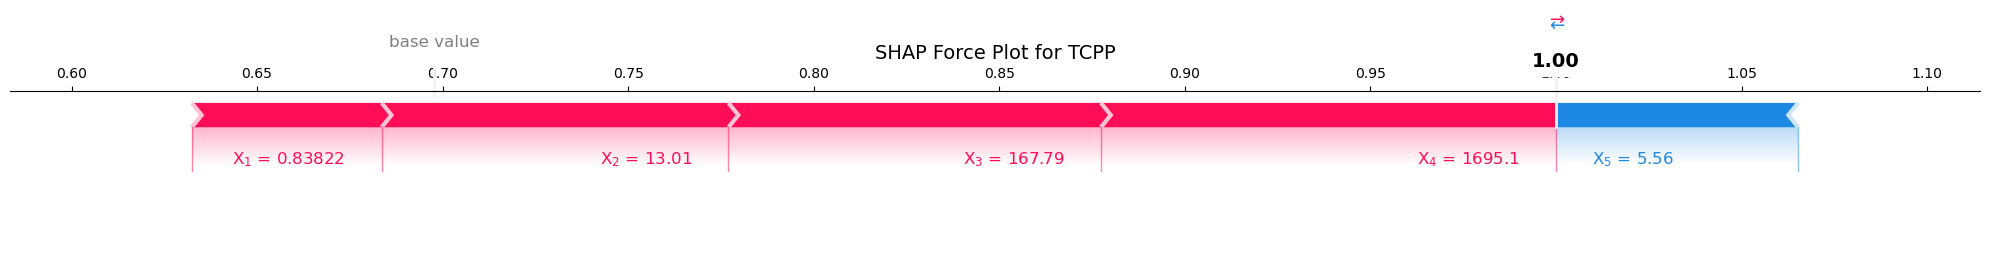

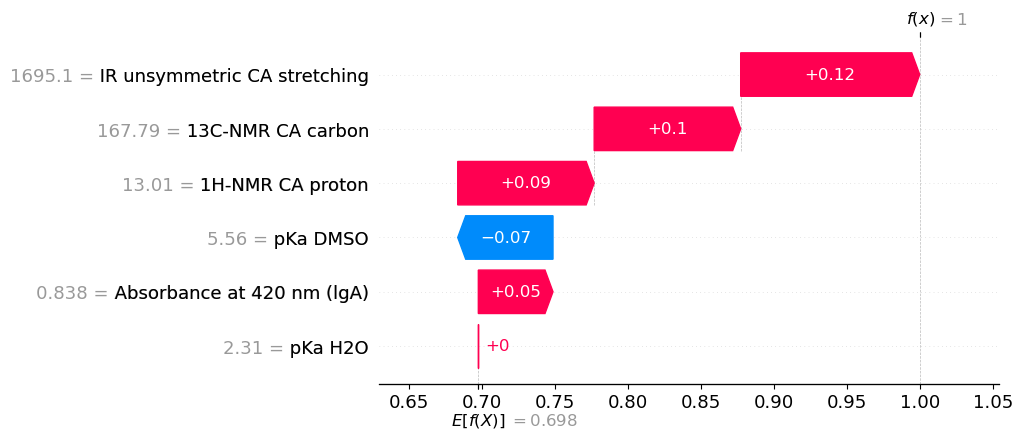

In [56]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor  # or other decision tree models

# Create SHAP explainer
explainer = shap.TreeExplainer(classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Plot summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:,:,1], X)
plt.tight_layout()
plt.show()

# Find the index of TCPP sample
tcpp_idx = df[df['Names'] == 'TCPP'].index[0]

# Get SHAP values for TCPP sample
tcpp_shap_values = shap_values[:,:,1][tcpp_idx]

# Create SHAP force plot
plt.figure(figsize=(12, 6))
feature_names_with_subscripts = []
for name in X.columns:
    if 'Absorbance' in name:
        name = name.replace('Absorbance at 420 nm (lgA)', 'X$_{1}$')
    if '1H-NMR' in name:
        name = name.replace('1H-NMR CA proton', 'X$_{2}$')   
    if '13C-NMR' in name:
        name = name.replace('13C-NMR CA carbon', 'X$_{3}$')
    if 'stretching' in name:
        name = name.replace('IR unsymmetric CA stretching', 'X$_{4}$')
    if 'pKa DMSO' in name:
        name = name.replace('pKa DMSO', 'X$_{5}$')
    if 'pKa H2O' in name:
        name = name.replace('pKa H2O', 'X$_{6}$')

    feature_names_with_subscripts.append(name)


shap_plot = shap.force_plot(
    explainer.expected_value[1], 
    tcpp_shap_values, 
    X.iloc[tcpp_idx],
    feature_names=feature_names_with_subscripts,
    matplotlib=True, 
    show=False,
    # plot_cmap='RdBu'
)

ax = plt.gca()
for text in ax.texts:
    if text.get_text() in ["higher", "lower",'f(x)']:
        text.set_visible(False)
plt.title('SHAP Force Plot for TCPP', fontsize=14)
plt.tight_layout()
plt.show()

# Create waterfall plot for TCPP
shap.waterfall_plot(shap.Explanation(
    values=tcpp_shap_values, 
    base_values=explainer.expected_value[1],
    data=X.iloc[tcpp_idx].values,
    feature_names=X.columns
))


<Figure size 1200x800 with 0 Axes>

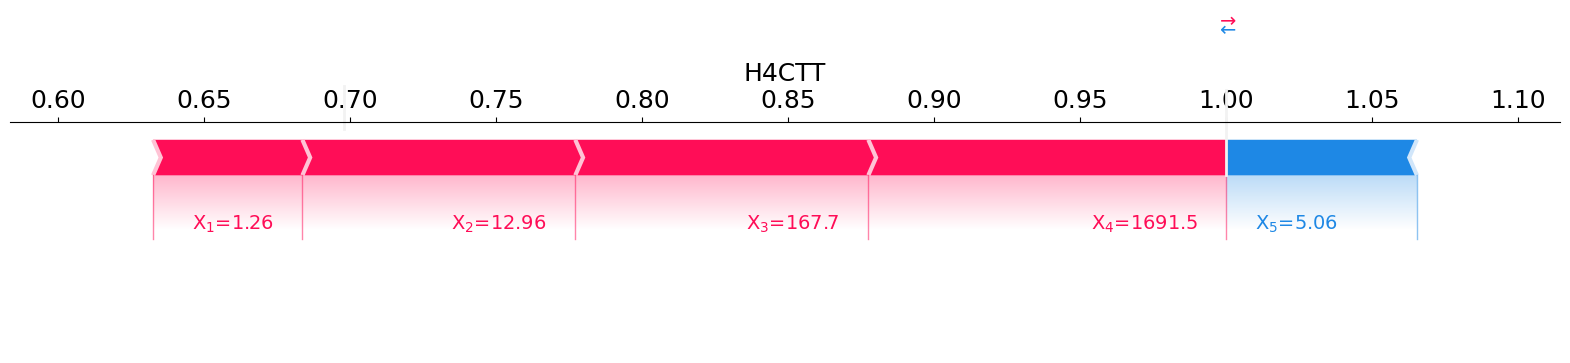

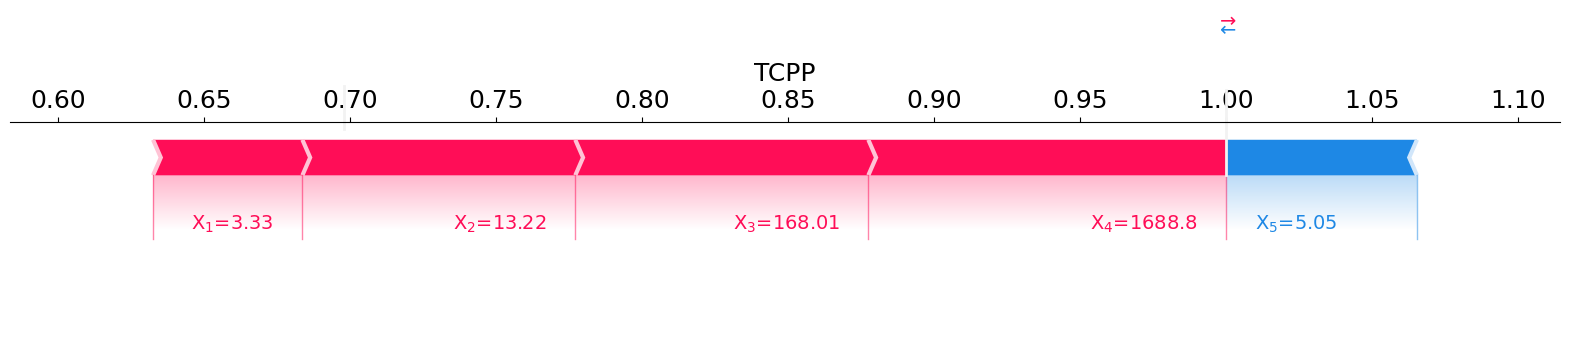

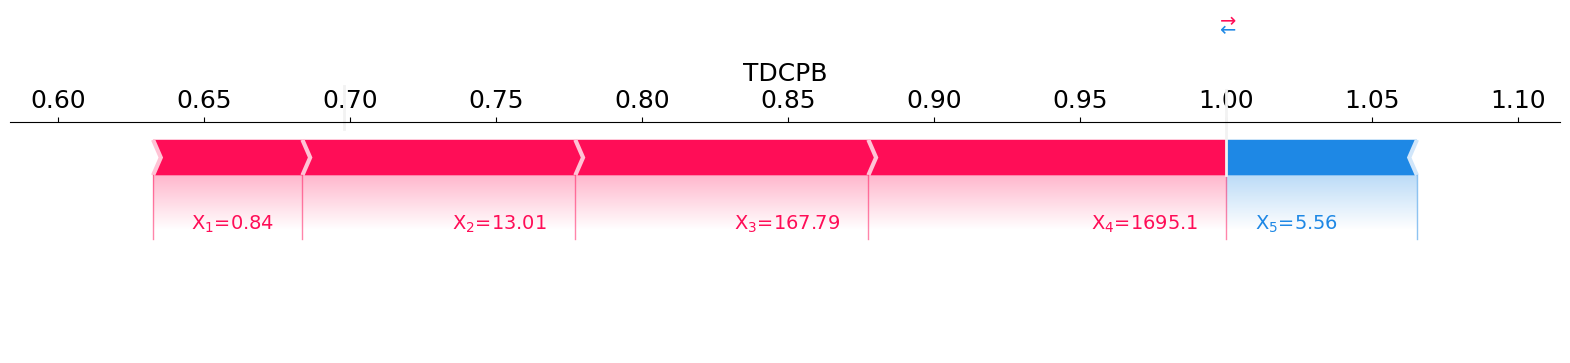

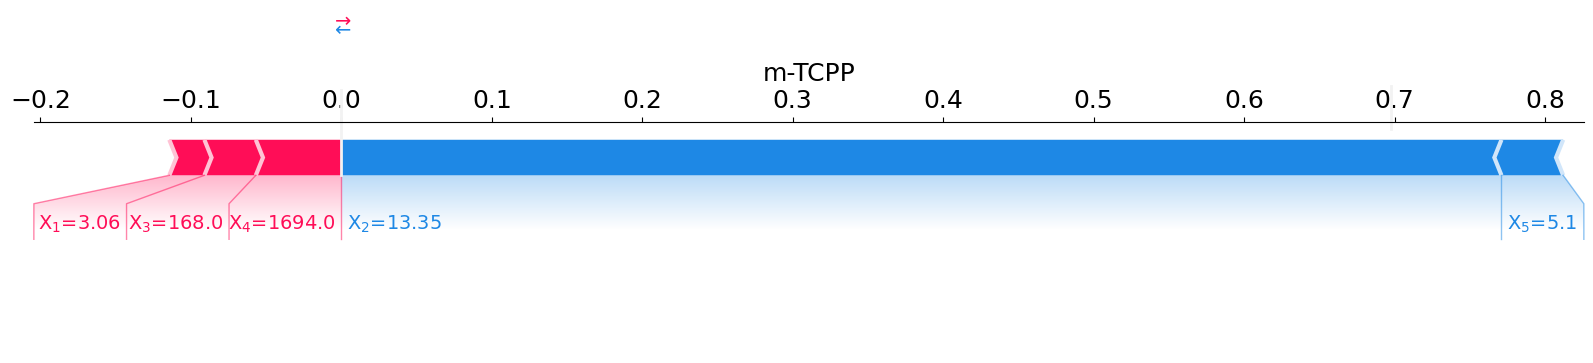

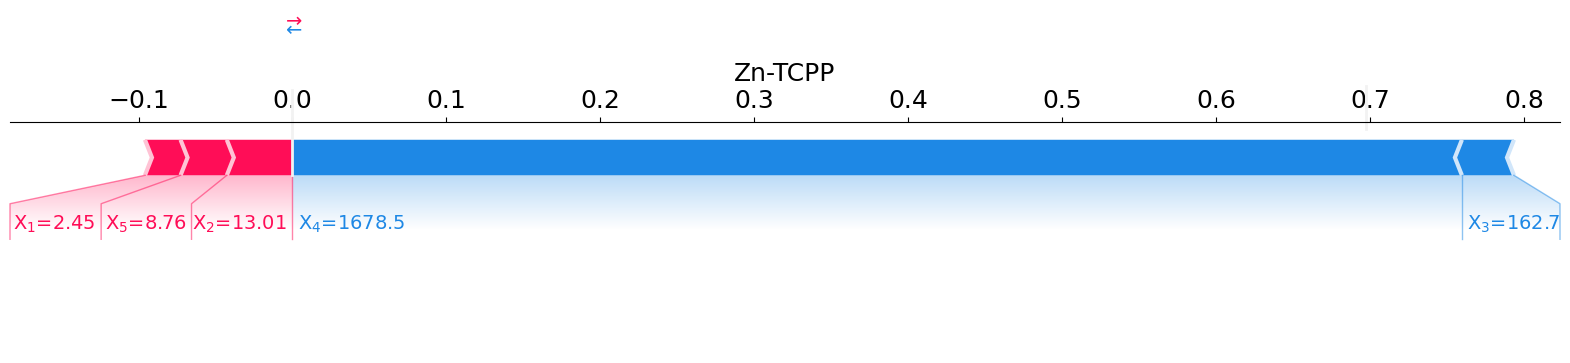

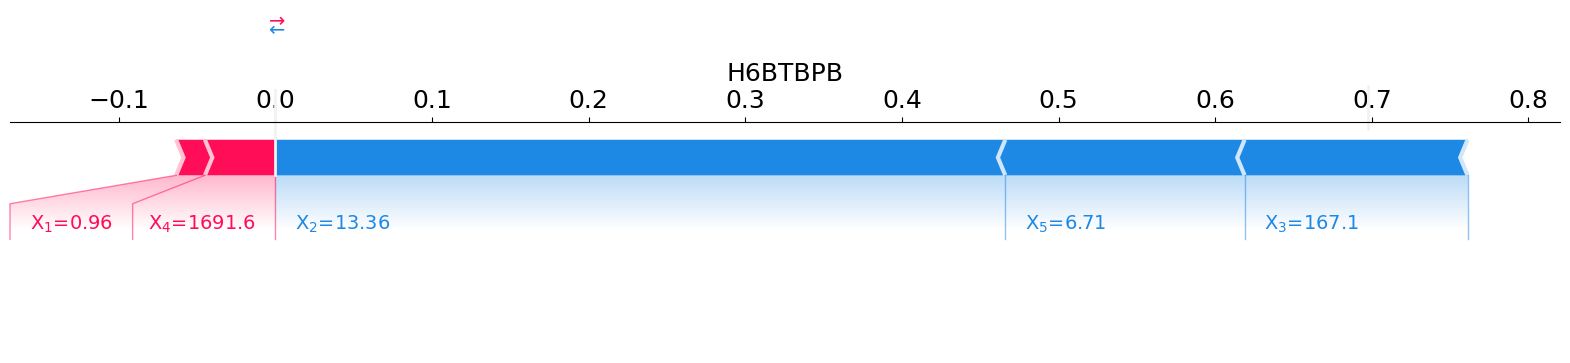

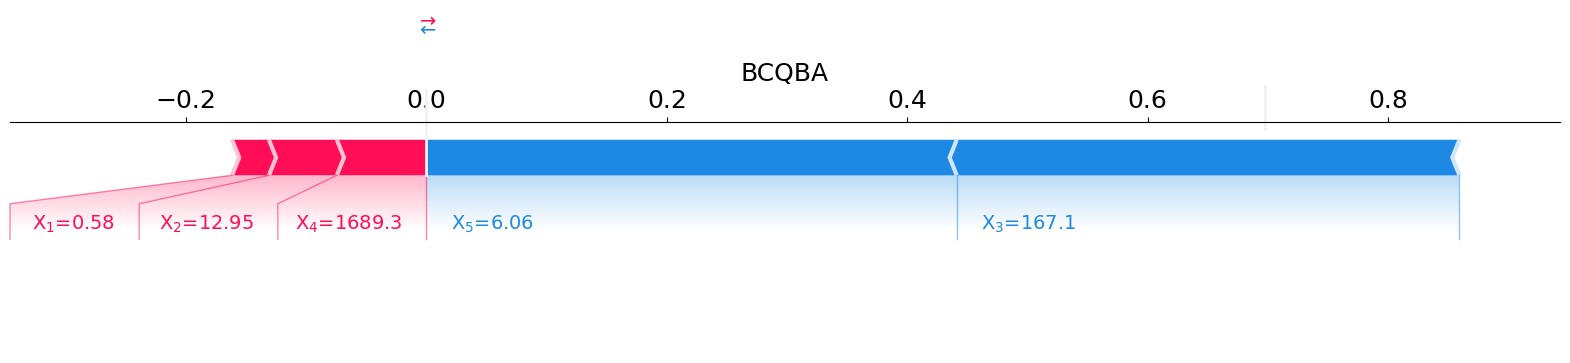

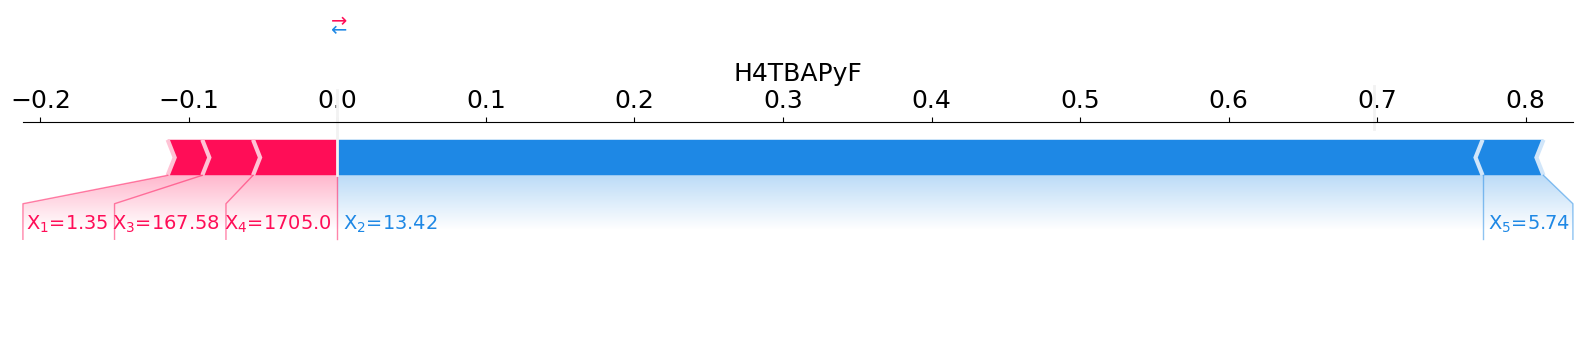

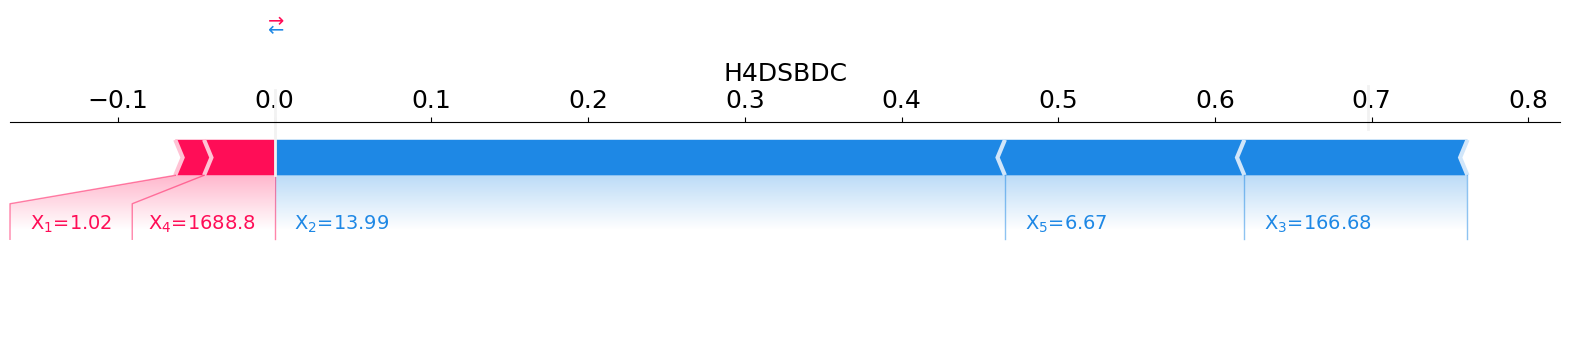

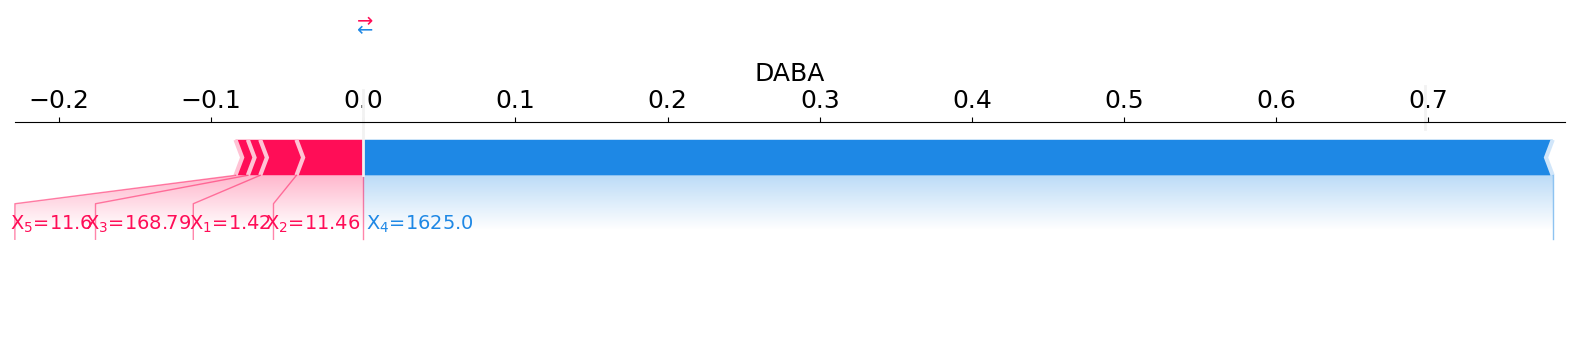

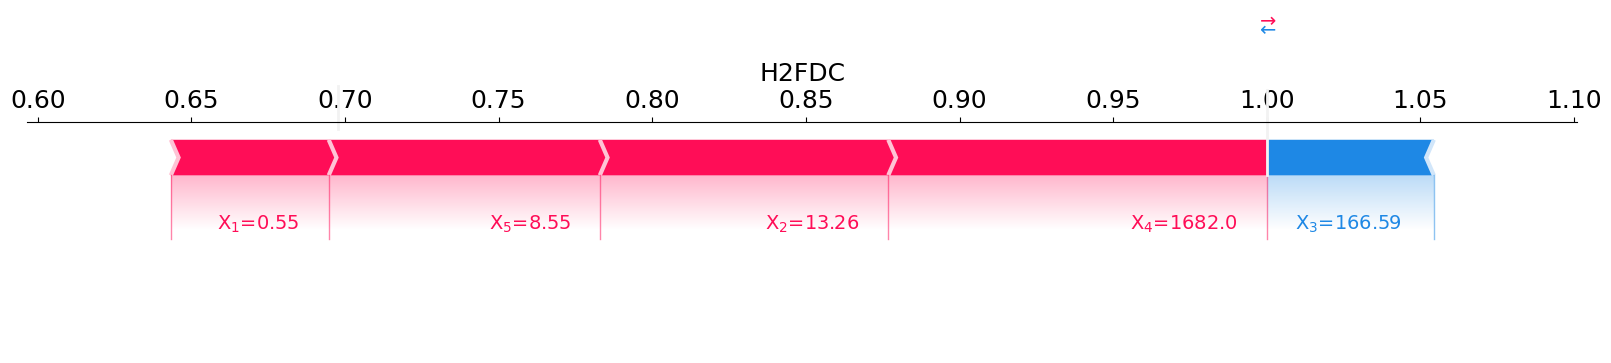

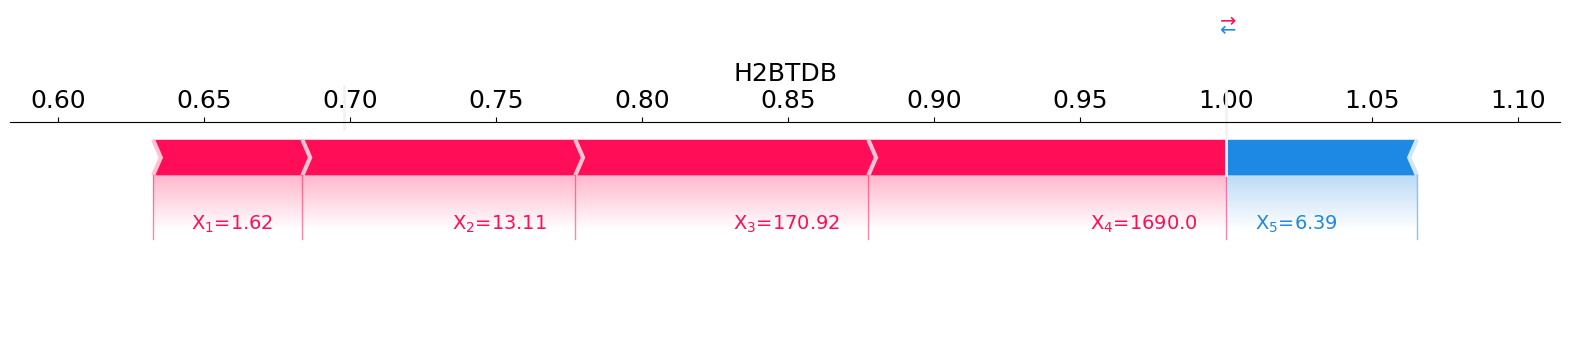

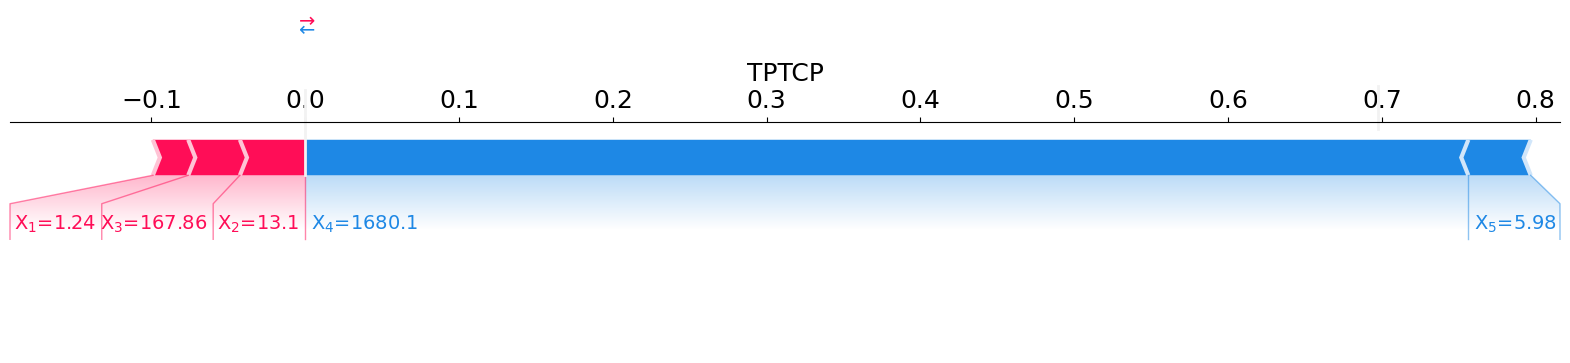

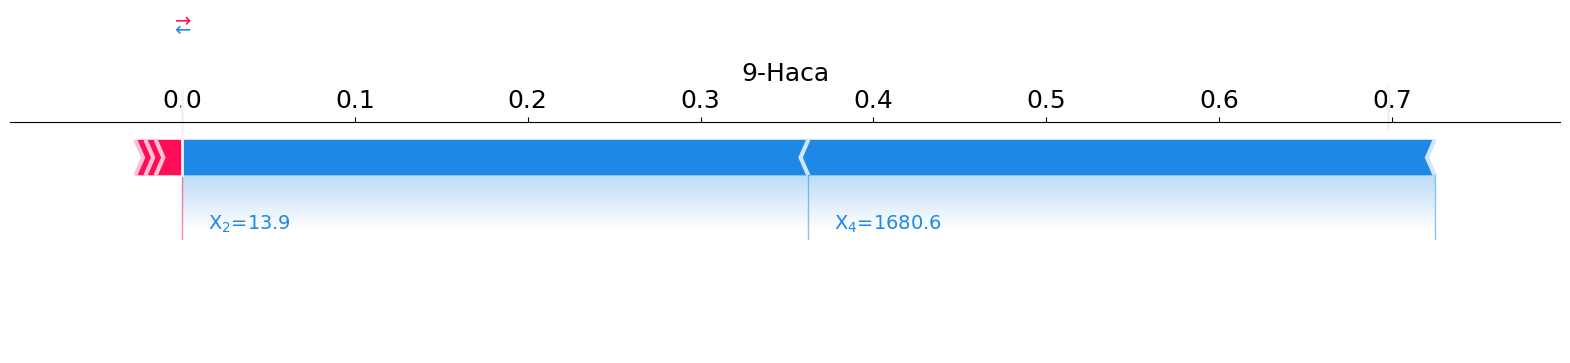

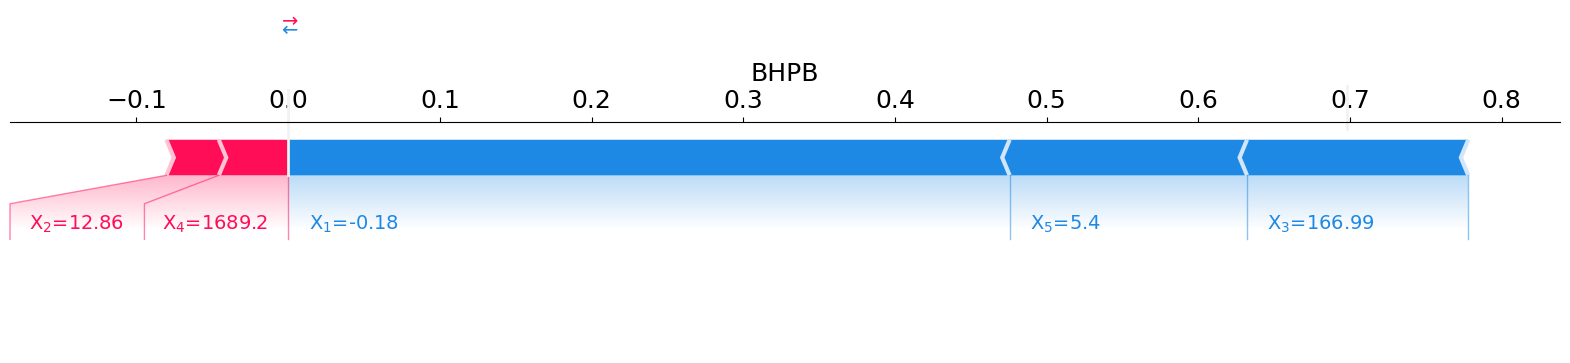

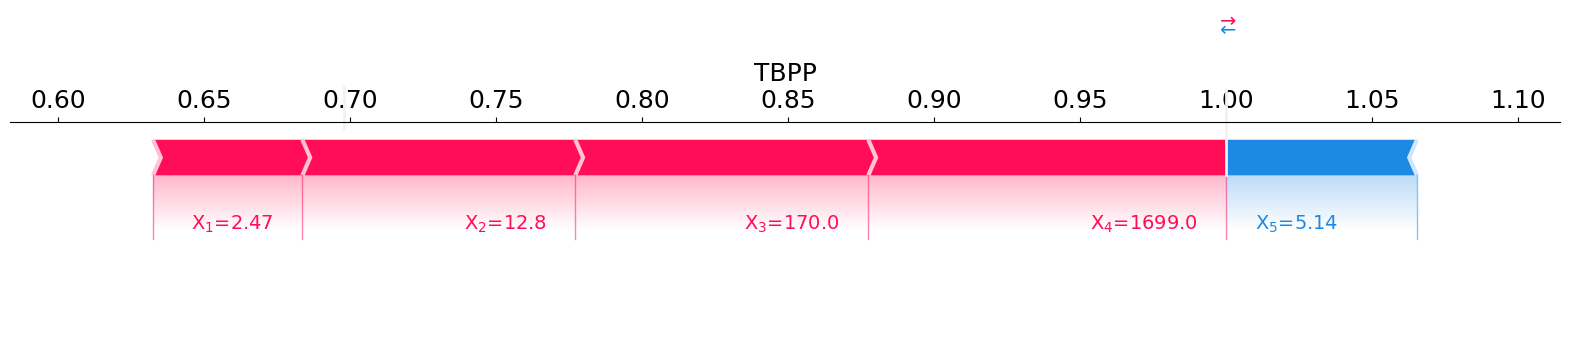

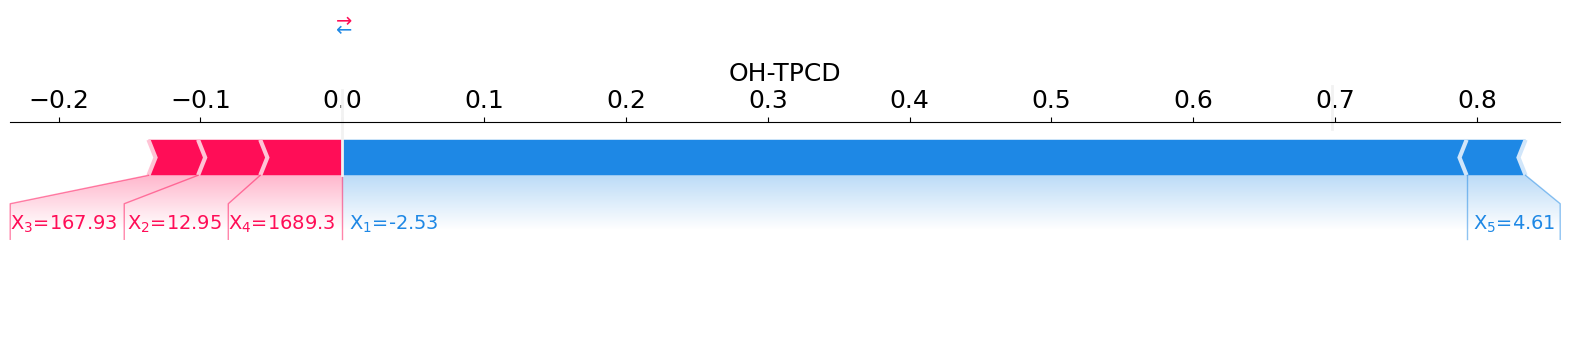

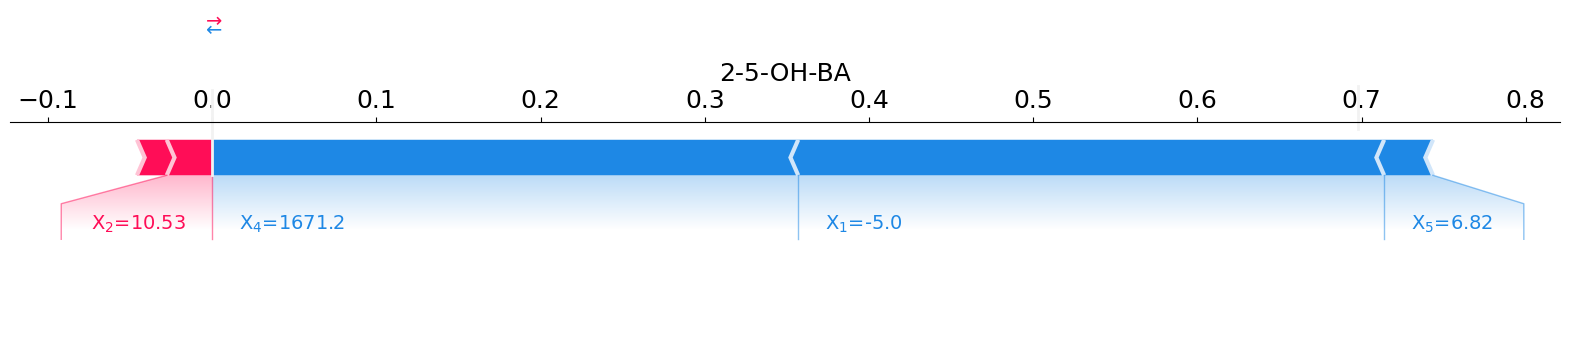

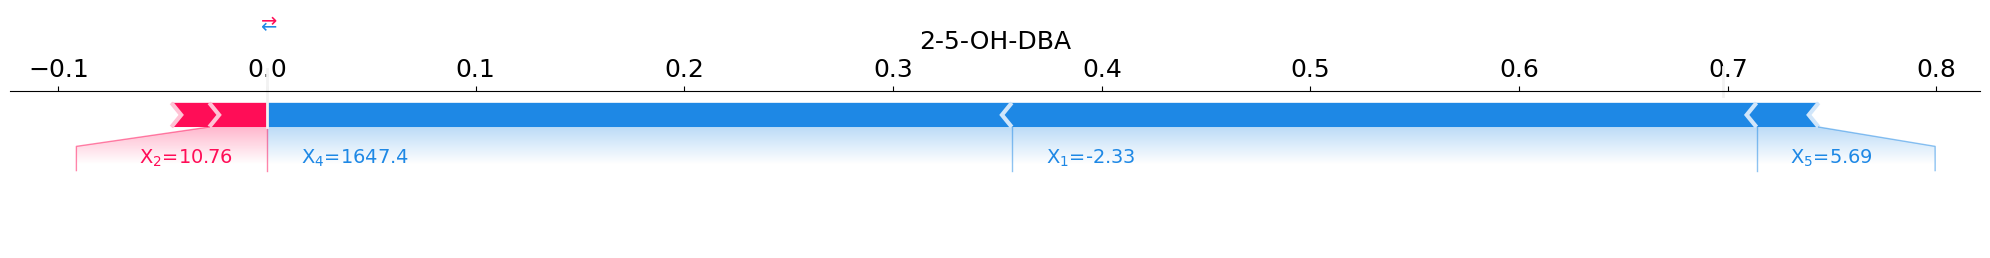

In [65]:

plt.figure(figsize=(12, 8))
font_size = 18

for i in range(X.shape[0]):
    
    sample_shap_values = shap_values[:,:,1][i]
    
    shap_plot = shap.force_plot(
        explainer.expected_value[1], 
        sample_shap_values, 
        X.iloc[i].round(2),
        feature_names=feature_names_with_subscripts,
        matplotlib=True, 
        show=False
    )
    
    ax = plt.gca()
    for text in ax.texts:
        if text.get_text() in ["higher", "lower", 'f(x)','1.00','0.00','-0.00','-->','<--','base value']:
            text.set_visible(False)
        else:
            text.set_text(text.get_text().replace(' ', ''))
            text.set_fontsize(14)
            
    for collection in ax.collections:
        collection.set_visible(False)
    
    plt.title(df['Names'].iloc[i], fontsize=font_size)
    
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.xaxis.label.set_fontsize(font_size)
    ax.yaxis.label.set_fontsize(font_size)

plt.tight_layout()
plt.show()


Dataset Head:
            CAS   Names                                             smiles  \
0  1821122-35-3   H4CTT  OC(C(C=C1)=CC=C1C2=CC3=C(C=C2C4=CC=C(C(O)=O)C=...   
1  1835723-11-9   H6PET  OC(C(C=C1)=CC=C1C2=CC(C34)=C(C(C5=C4C=C(C6=CC=...   
2    14609-54-2    TCPP  O=C(O)C(C=C1)=CC=C1/C(C2=CC=C(/C(C3=CC=C(C(O)=...   
3  1331745-95-9   TDCPB  O=C(O)C(C=C1)=CC=C1C2=CC(C3=CC(C4=CC(C5=CC=C(C...   
4    70152-54-4  m-TCPP  O=C(C1=CC(/C(C2=CC=C(/C(C3=CC=CC(C(O)=O)=C3)=C...   

   1H-NMR CA proton  13C-NMR CA carbon  IR unsymmetric CA stretching  pKa H2O  \
0             12.96             167.70                        1691.5     2.19   
1             12.92             167.59                           NaN     2.36   
2             13.22             168.01                        1688.8     2.33   
3             13.01             167.79                        1695.1     2.31   
4             13.35             168.00                        1694.0     2.36   

   pKa DMSO  Absorbance at 420

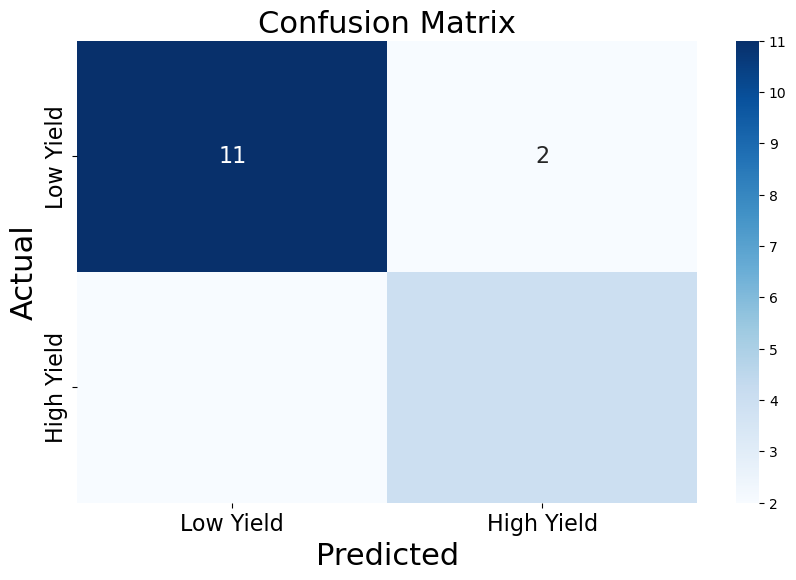

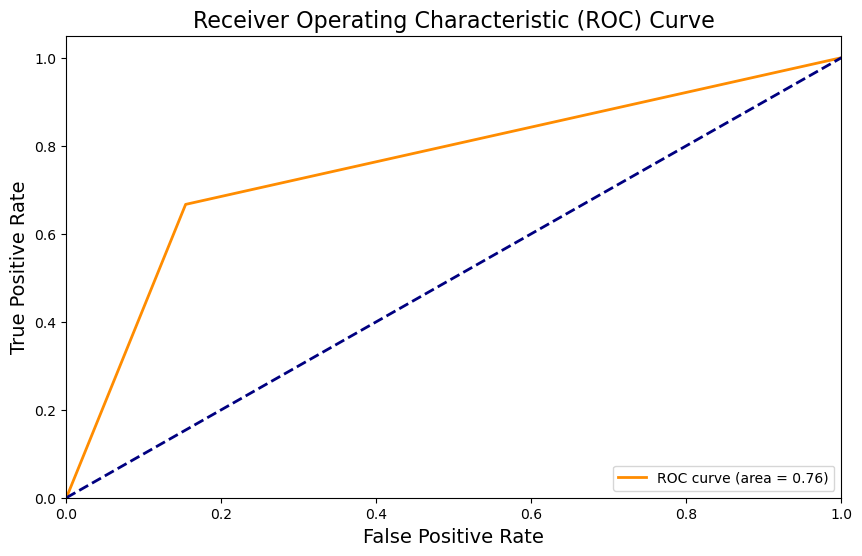

|--- IR unsymmetric CA stretching <= 1681.30
|   |--- class: 0
|--- IR unsymmetric CA stretching >  1681.30
|   |--- 1H-NMR CA proton <= 13.31
|   |   |--- Absorbance at 420 nm (lgA) <= 0.18
|   |   |   |--- class: 0
|   |   |--- Absorbance at 420 nm (lgA) >  0.18
|   |   |   |--- 13C-NMR CA carbon <= 167.40
|   |   |   |   |--- pKa DMSO <= 7.31
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- pKa DMSO >  7.31
|   |   |   |   |   |--- class: 1
|   |   |   |--- 13C-NMR CA carbon >  167.40
|   |   |   |   |--- class: 1
|   |--- 1H-NMR CA proton >  13.31
|   |   |--- class: 0



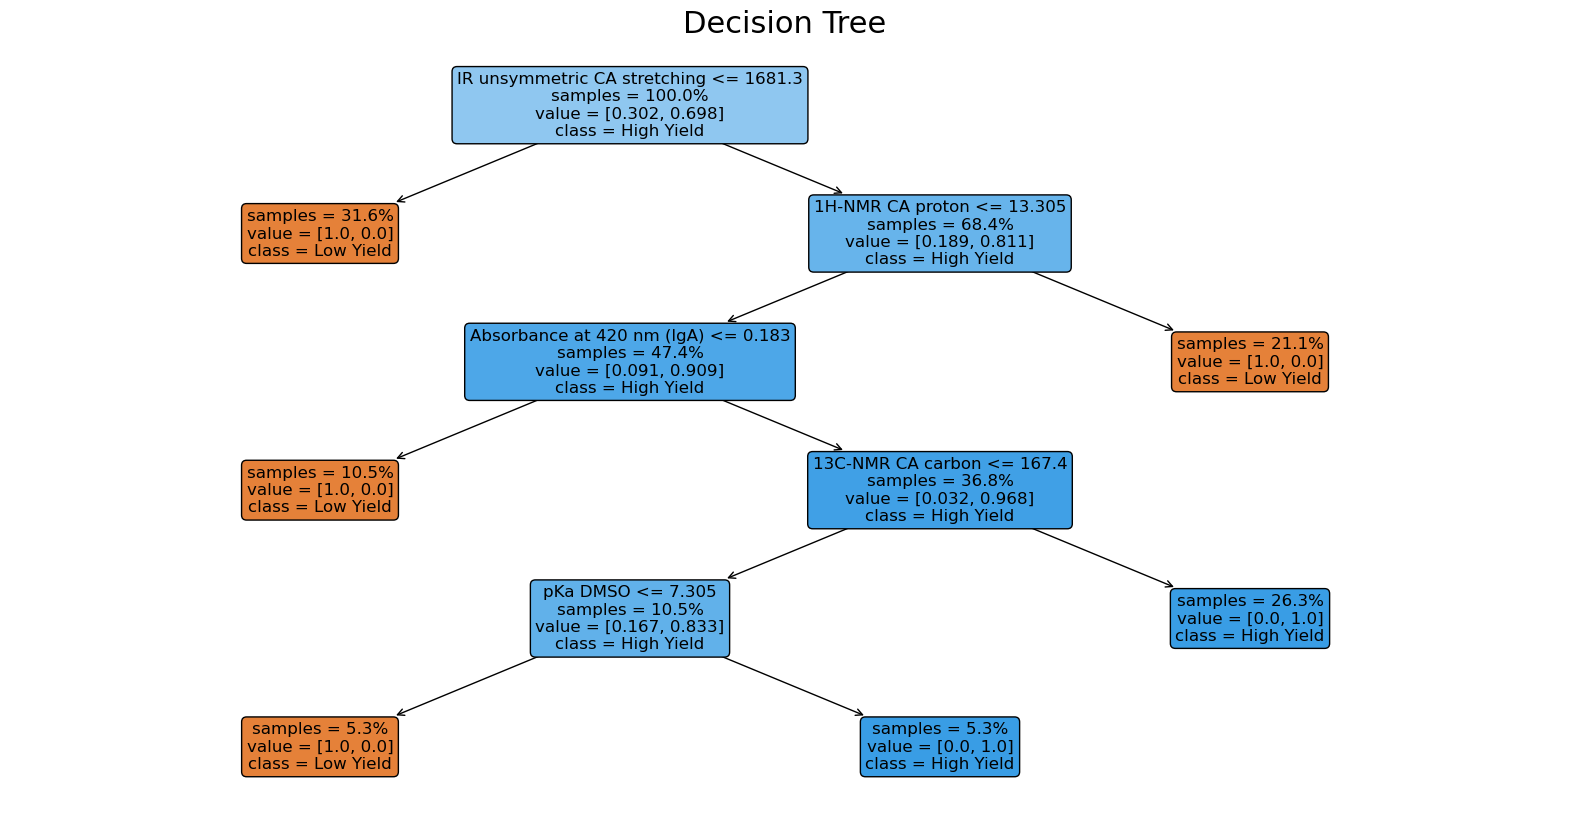

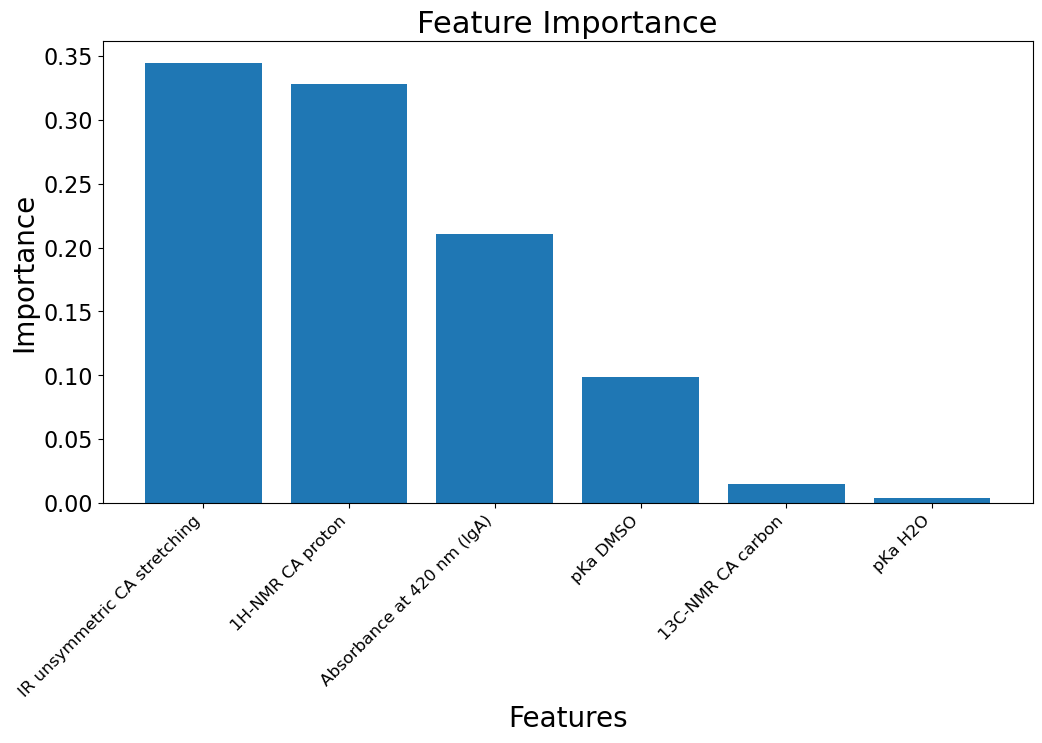

Mislabelled Data Yields:
    Yield
7    2.46
11   6.56
13   0.00
16   5.00


In [1]:
#use weighted feature importance
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'carboxylates.csv'
df = pd.read_csv(file_path)

# Inspect the dataset
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())

# Drop rows with missing values
df = df.dropna()

# Convert the problem to a classification problem
# Define high yield as yield >=5, and low yield as yield < 5
df['Yield_Class'] = np.where(df['Yield'] >= 5, 1, 0)

# Split the dataset into features and target variable for classification
X = df.drop(columns=['CAS', 'Names', 'smiles', 'Yield', 'Yield_Class'])
y = df['Yield_Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the DecisionTreeClassifier with class weights
class_weights = {1: 5, 0: 1}
hyperparameters = {
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'class_weight': class_weights
}
classifier = DecisionTreeClassifier(random_state=42, **hyperparameters)

# Initialize LOOCV for classification
accuracy_list = []
y_true = []
y_pred_class_list = []
y_prob_list = []
feature_importances = np.zeros(X.shape[1])

# Perform LOOCV for classification
loo = LeaveOneOut()
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    classifier.fit(X_train, y_train)
    y_pred_class = classifier.predict(X_test)
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_class))
    y_true.extend(y_test)
    y_pred_class_list.extend(y_pred_class)
    y_prob_list.extend(y_pred_prob)

    # Calculate feature importance
    importance = classifier.feature_importances_
    weight = 3 if y_pred_class == y_test.values else 1
    feature_importances += weight * importance

# Normalize feature importances
feature_importances /= (3 * sum(np.array(y_pred_class_list) == np.array(y_true)) + sum(np.array(y_pred_class_list) != np.array(y_true)))

# Calculate average accuracy
mean_accuracy = np.mean(accuracy_list)

print(f"Classification Model Accuracy: {mean_accuracy}")
print("Classification Report:")
print(classification_report(y_true, y_pred_class_list, target_names=['Low Yield', 'High Yield']))

# Plotting the classification results
plt.figure(figsize=(10, 6))
conf_mat = confusion_matrix(y_true, y_pred_class_list)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 16})
plt.xlabel("Predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)
plt.title("Confusion Matrix", fontsize=22)
plt.xticks(ticks=[0.5, 1.5], labels=['Low Yield', 'High Yield'], fontsize=16)
plt.yticks(ticks=[0.5, 1.5], labels=['Low Yield', 'High Yield'], fontsize=16)
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_prob_list)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.show()

# Train the classifier on the full dataset for visualization
classifier.fit(X, y)

# Print the decision tree as text
tree_text = export_text(classifier, feature_names=list(X.columns))
print(tree_text)

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(classifier, feature_names=list(X.columns), class_names=['Low Yield', 'High Yield'], filled=True, rounded=True, fontsize=12, proportion=True, impurity=False)
plt.title('Decision Tree', fontsize=22)
plt.show()

# Plot feature importance
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance", fontsize=22)
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [list(X.columns)[i] for i in indices], rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=16)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Importance", fontsize=20)
plt.show()

# Collect mislabelled data
mislabelled_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred_class_list)) if true != pred]
mislabelled_data = df.iloc[mislabelled_indices]

# Show their yields
print("Mislabelled Data Yields:")
print(mislabelled_data[['Yield']])


In [ ]:
#the mislabelled data
mislabelled_data

,CAS,Names,smiles,1H-NMR CA proton,13C-NMR CA carbon,IR unsymmetric CA stretching,pKa H2O,pKa DMSO,Absorbance at 420 nm (lgA),Yield,Yield_Class
7,1643112-46-2,BCQBA,O=C(O)C(C=C1)=CC=C1C(C=C2)=CC=C2C3=CC(C4=CC=C(...,12.95,167.10,1689.3,3.12,6.06,0.58320,2.46,0
11,792-26-7,H2FDC,OC(C(C=C1)=CC2=C1C(C=CC(C(O)=O)=C3)=C3O2)=O,13.26,166.59,1682.0,3.28,8.55,0.54654,6.56,1
13,933047-52-0,TPTCP,O=C(C1=CC=C(C2=CC(C3=CC=C(C(O)=O)C=C3)=C4C=CC(...,13.10,167.86,1680.1,2.77,5.98,1.23805,0.00,0
16,609365-68-6,TBPP,O=C(O)C(C=C1)=CC=C1C(C=C2)=CC=C2/C(C(C=C/3)=NC...,12.80,170.00,1699.0,2.96,5.14,2.46716,5.00,1


In [ ]:
#draw the one that is truly misclassified

from rdkit import Chem
from rdkit.Chem import Draw

# SMILES string for TPTCP
smiles_tptcp = df[df['Names'] == 'TPTCP']['smiles'].values[0]

# Generate the molecule from SMILES
mol_tptcp = Chem.MolFromSmiles(smiles_tptcp)

# Draw the molecule
img = Draw.MolToImage(mol_tptcp, size=(300, 300))
img.show()